# Problem 1

![](https://media.discordapp.net/attachments/947918193924636695/1224206416567468113/Screenshot_20240401_125714.jpg?ex=661ca612&is=660a3112&hm=3c25abb46718571c67011264bb153ddfb2c6480b58012d0bba8d0e6b7977fcb3&=&format=webp&width=1358&height=1118)

# Problem 2

![](https://cdn.discordapp.com/attachments/947918193924636695/1224206416818995261/Screenshot_20240401_125730.jpg?ex=661ca612&is=660a3112&hm=1c70cffaa7c38622503082ded6cfd0ffaf2e4eacc7df5d8ae4a63d75bdf1f015&)

# Problem 3

![](https://cdn.discordapp.com/attachments/947918193924636695/1224206417041297462/Screenshot_20240401_125751.jpg?ex=661ca612&is=660a3112&hm=37e9c0de082af5895058af6d4ddf92c6bd47fbc574cca932a91a61cfefc842b5&)

# Problem 4

![](https://cdn.discordapp.com/attachments/947918193924636695/1224206417334894645/Screenshot_20240401_125810.jpg?ex=661ca612&is=660a3112&hm=03d91face1a87ad1baecb61059e5dc3916edb67a85668ff660fc71d857eee8ad&)

# Problem 5

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.datasets.mnist as mnist
from IPython.display import clear_output

In [3]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(28*28, 1, bias=True)
  def forward(self, x):
    x = x.view(-1, 28*28)
    x = self.linear(x)
    x = torch.cat([sigmoid(-x), sigmoid(x)], dim=-1)
    return x

In [4]:
dataset = mnist.MNIST('./data', download=True)
data = dataset.data/255
label = dataset.targets
mask = (label == 4) | (label == 9)
data = data[mask]
label = label[mask]
y_true = torch.zeros((len(label), 2), dtype=torch.float32)
y_true[:, 0] = (label == 4)
y_true[:, 1] = (label == 9)

X_train = data[:1000].float()
y_train = y_true[:1000]
X_test = data[1000:].float()
y_test = y_true[1000:]

In [11]:
def KL_divergence(y_true, y_pred):
  return -torch.sum(
    y_true * torch.log(y_pred)
  )

def MSE(y_true, y_pred):
  diff = y_true - y_pred
  return torch.mean(
    diff * diff
  )

In [6]:
model = Model()
model(data[0].float().unsqueeze(0))

tensor([[0.5792, 0.4208]], grad_fn=<CatBackward0>)

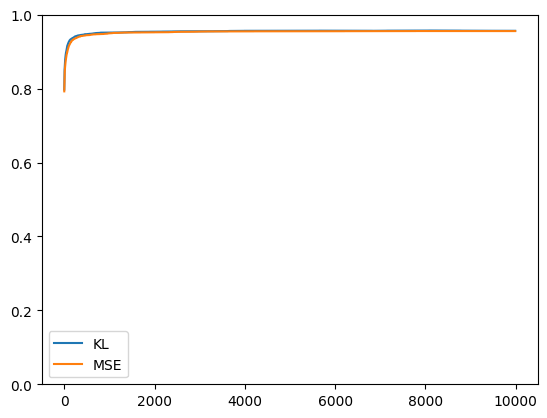

epoch 9990 KL: 1.1266645193099976 MSE: 0.01183449849486351
accuracy KL: 0.9563525159855435 MSE: 0.9556111574460199


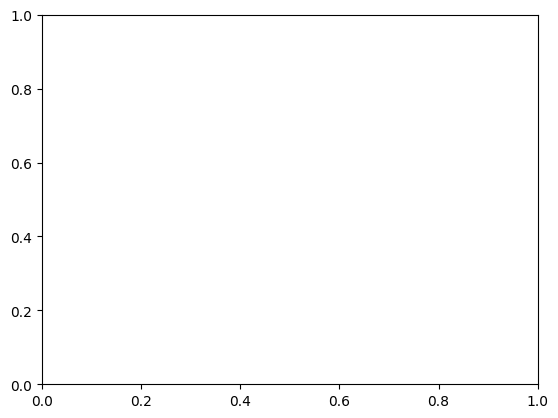

In [17]:
BATCH_SIZE = 32
model_KL = Model()
model_MSE = Model()

model_KL.linear.weight.data = torch.normal(0, 1e-6, size=model_KL.linear.weight.data.shape)
model_KL.linear.bias.data = torch.normal(0, 1e-6, size=model_KL.linear.bias.data.shape)

model_MSE.linear.weight.data = torch.normal(0, 1e-6, size=model_MSE.linear.weight.data.shape)
model_MSE.linear.bias.data = torch.normal(0, 1e-6, size=model_MSE.linear.bias.data.shape)

optimizer_KL = torch.optim.SGD(model_KL.parameters(), lr=1e-3/BATCH_SIZE)
optimizer_MSE = torch.optim.SGD(model_MSE.parameters(), lr=1e-3)

kl_log = []
mse_log = []

for epoch in range(10000):
  for i in range(BATCH_SIZE, len(y_train), BATCH_SIZE):
    y_pred_KL = model_KL(X_train[i-BATCH_SIZE:i].float())
    y_pred_MSE = model_MSE(X_train[i-BATCH_SIZE:i].float())

    loss_KL = KL_divergence(y_train[i-BATCH_SIZE:i], y_pred_KL)
    loss_MSE = MSE(y_train[i-BATCH_SIZE:i], y_pred_MSE)

    optimizer_KL.zero_grad()
    optimizer_MSE.zero_grad()

    loss_KL.backward()
    loss_MSE.backward()

    optimizer_KL.step()
    optimizer_MSE.step()
  
  y_pred_KL = model_KL(X_test.float())
  y_pred_MSE = model_MSE(X_test.float())

  kl_log.append(torch.sum(torch.argmax(y_pred_KL, dim=1) == torch.argmax(y_test, dim=1)).item()/len(y_test))
  mse_log.append(torch.sum(torch.argmax(y_pred_MSE, dim=1) == torch.argmax(y_test, dim=1)).item()/len(y_test))
  if epoch % 10 == 0:
    clear_output(wait=True)
    plt.plot(kl_log, label='KL')
    plt.plot(mse_log, label='MSE')
    plt.legend()
    plt.show()
    plt.ylim(0,1)
    print(f'epoch {epoch} KL: {loss_KL.item()} MSE: {loss_MSE.item()}')
    print(f'accuracy KL: {kl_log[-1]} MSE: {mse_log[-1]}')



In [9]:
import time


BATCH_SIZE = 32
model_KL = Model()

model_KL.linear.weight.data = torch.normal(0, 1e-6, size=model_KL.linear.weight.data.shape)
model_KL.linear.bias.data = torch.normal(0, 1e-6, size=model_KL.linear.bias.data.shape)

optimizer_KL = torch.optim.SGD(model_KL.parameters(), lr=1e-3/BATCH_SIZE)

kl_log = []


start = time.time()
for epoch in range(1000):
  for i in range(BATCH_SIZE, len(y_train), BATCH_SIZE):
    y_pred_KL = model_KL(X_train[i-BATCH_SIZE:i].float())

    loss_KL = KL_divergence(y_train[i-BATCH_SIZE:i], y_pred_KL)

    optimizer_KL.zero_grad()

    loss_KL.backward()

    optimizer_KL.step()
  
  y_pred_KL = model_KL(X_test.float())
  kl_log.append(torch.sum(torch.argmax(y_pred_KL, dim=1) == torch.argmax(y_test, dim=1)).item()/len(y_test))
end = time.time()
print("Elapsed Time: ", end-start)


Elapsed Time:  6.323716878890991


In [13]:
BATCH_SIZE = 32
model_MSE = Model()

model_MSE.linear.weight.data = torch.normal(0, 1e-6, size=model_MSE.linear.weight.data.shape)
model_MSE.linear.bias.data = torch.normal(0, 1e-6, size=model_MSE.linear.bias.data.shape)

optimizer_MSE = torch.optim.SGD(model_MSE.parameters(), lr=1e-3)

MSE = torch.

mse_log = []
start = time.time()
for epoch in range(1000):
  for i in range(BATCH_SIZE, len(y_train), BATCH_SIZE):
    y_pred_MSE = model_MSE(X_train[i-BATCH_SIZE:i].float())

    loss_MSE = MSE(y_train[i-BATCH_SIZE:i], y_pred_MSE)

    optimizer_MSE.zero_grad()

    loss_MSE.backward()

    optimizer_MSE.step()
  
  y_pred_MSE = model_MSE(X_test.float())

  mse_log.append(torch.sum(torch.argmax(y_pred_MSE, dim=1) == torch.argmax(y_test, dim=1)).item()/len(y_test))
end = time.time()
print("Elapsed Time:", end-start)

Elapsed Time: 6.276560068130493


두 Loss 모두 잘 동작하여 정확도가 95% 이상이며, 동작하는 시간도 거의 일치한다고 볼 수 있다. 그렇기에 두 Loss의 성능 차이가 없으며 둘중 어느 것을 사용해도 무관하다고 볼 수 있다.

# Problem 6

![](https://cdn.discordapp.com/attachments/947918193924636695/1224206417599140001/Screenshot_20240401_125838.jpg?ex=661ca612&is=660a3112&hm=fe516b7ac6463a0285a8ae866b28b3162c4e5ab51e7780c0b22059ece8671bc8&)

![](https://cdn.discordapp.com/attachments/947918193924636695/1224206417892868167/Screenshot_20240401_125850.jpg?ex=661ca612&is=660a3112&hm=4fc28a18dbd1087c6add873e595c77fe399be1289d8efa715c29627b8836b39a&)

# Problem 7

In [14]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps' if torch.backends.mps.is_available() else "cpu")
# MNIST dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False, 
                              transform=transforms.ToTensor())

In [19]:
# Modern LeNet uses this layer for C3
class C3_layer_full(nn.Module):
    def __init__(self):
        super(C3_layer_full, self).__init__()
        self.conv_layer = nn.Conv2d(6, 16, kernel_size=5)

    def forward(self, x):
        return self.conv_layer(x)

# Original LeNet uses this layer for C3
class C3_layer(nn.Module):
    def __init__(self):
        super(C3_layer, self).__init__()
        self.ch_in_3 = [[0, 1, 2],
                        [1, 2, 3],
                        [2, 3, 4],
                        [3, 4, 5],
                        [0, 4, 5],
                        [0, 1, 5]] # filter with 3 subset of input channels
        self.ch_in_4 = [[0, 1, 2, 3],
                        [1, 2, 3, 4],
                        [2, 3, 4, 5],
                        [0, 3, 4, 5],
                        [0, 1, 4, 5],
                        [0, 1, 2, 5],
                        [0, 1, 3, 4],
                        [1, 2, 4, 5],
                        [0, 2, 3, 5]] # filter with 4 subset of input channels
        # put implementation here
        self.ch_in_6 = [[0, 1, 2, 3, 4, 5]]
        self.Conv_channel_3 = nn.ModuleList([
            nn.Conv2d(3, 1, kernel_size=5)
            for _ in range(6)
        ])
        self.Conv_channel_4 = nn.ModuleList([
            nn.Conv2d(4, 1, kernel_size=5)
            for _ in range(9)
        ])
        self.Conv_channel_6 = nn.ModuleList([
            nn.Conv2d(6, 1, kernel_size=5)
        ])
    def forward(self, x):
        # put implementation here
        return torch.cat([
            Conv(x[:, channel, :, :])
            for Conv, channel in zip(
                self.Conv_channel_3,
                self.ch_in_3
            )
        ]+[
            Conv(x[:, channel, :, :])
            for Conv, channel in zip(
                self.Conv_channel_4,
                self.ch_in_4
            )
        ]+[
            Conv(x[:, channel, :, :])
            for Conv, channel in zip(
                self.Conv_channel_6,
                self.ch_in_6
            )
        ])
    
class LeNet(nn.Module) :
    def __init__(self) :
        super(LeNet, self).__init__()
        #padding=2 makes 28x28 image into 32x32
        self.C1_layer = nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=5, padding=2),
                nn.Tanh()
                )
        self.P2_layer = nn.Sequential(
                nn.AvgPool2d(kernel_size=2, stride=2),
                nn.Tanh()
                )
        self.C3_layer = nn.Sequential(
                #C3_layer_full(),
                C3_layer(),
                nn.Tanh()
                )
        self.P4_layer = nn.Sequential(
                nn.AvgPool2d(kernel_size=2, stride=2),
                nn.Tanh()
                )
        self.C5_layer = nn.Sequential(
                nn.Linear(5*5*16, 120),
                nn.Tanh()
                )
        self.F6_layer = nn.Sequential(
                nn.Linear(120, 84),
                nn.Tanh()
                )
        self.F7_layer = nn.Linear(84, 10)
        self.tanh = nn.Tanh()
        
    def forward(self, x) :
        output = self.C1_layer(x)
        output = self.P2_layer(output)
        output = self.C3_layer(output)
        output = self.P4_layer(output)
        output = output.view(-1,5*5*16)
        output = self.C5_layer(output)
        output = self.F6_layer(output)
        output = self.F7_layer(output)
        return output

In [25]:
model = LeNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# print total number of trainable parameters
param_ct = sum([p.numel() for p in model.parameters()])
print(f"Total number of trainable parameters: {param_ct}")


Total number of trainable parameters: 60806


$((6\cdot5\cdot5)+1)
+\{((3\cdot5\cdot5)+1)\cdot6+((4\cdot5\cdot5)+1)\cdot9+ 
((6\cdot5\cdot5)+1)\}+(120\cdot400+120)+(84\cdot120+84)+(10\cdot84+10)=60806 $

In [26]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

import time
start = time.time()
for epoch in range(10) :
    print("{}th epoch starting.".format(epoch))
    for images, labels in train_loader :
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        optimizer.step()
end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


0th epoch starting.
1th epoch starting.
2th epoch starting.
3th epoch starting.
4th epoch starting.
5th epoch starting.
6th epoch starting.
7th epoch starting.
8th epoch starting.
9th epoch starting.
Time ellapsed in training is: 195.4492208957672


In [27]:
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

for images, labels in test_loader :
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    test_loss += loss_function(output, labels).item()

    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    
    total += labels.size(0)
            
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))


[Test set] Average loss: 0.0229, Accuracy: 1313/10000 (13.13%)

